In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics

from ast import literal_eval

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model, stocks_numbers
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_length = 24000
stocks = stocks_numbers.chosen_stocks
should_save_fig = False

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d,  d_test = lob.load_prepared_data(s, length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d['prev_queue_imbalance'] = [None] + d['queue_imbalance'].iloc[0:len(d)-1].values.tolist()
    d.dropna(inplace=True)
    d_test['prev_queue_imbalance'] = [None] + d_test['queue_imbalance'].iloc[0:len(d_test)-1].values.tolist()
    d_test.dropna(inplace=True)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

In [4]:
d_stocks['3459'].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,prev_queue_imbalance
2013-09-02 08:31:00,2013-09-02 08:31:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 19522.0), (750.0, 51865.0), (750.5, 1...",748.5,749.5,749.0,19522.0,8078.0,0.0,-0.414638,-0.573878
2013-09-02 08:32:00,2013-09-02 08:32:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 13371.0), (750.0, 51046.0), (750.5, 1...",748.5,749.5,749.0,13371.0,16818.0,0.0,0.114181,-0.414638
2013-09-02 08:33:00,2013-09-02 08:33:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 20645.0), (750.0, 51474.0), (750.5, 1...",748.5,749.5,749.0,20645.0,7206.0,0.0,-0.482532,0.114181
2013-09-02 08:34:00,2013-09-02 08:34:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 14676.0), (750.0, 51474.0), (750.5, 1...",748.5,749.5,749.0,14676.0,7206.0,0.0,-0.341376,-0.482532
2013-09-02 08:35:00,2013-09-02 08:35:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.0, 9652.0), (749.5, 35846.0), (750.0, 42...",748.0,749.0,748.5,9652.0,5395.0,1.0,-0.282914,-0.341376


## SVM with queue imbalance

In [5]:
df_res = {}
for s in stocks:
    df_res_temp = pd.read_csv('../svm_queue_imbalance/res_svm/svm_linear_{}_len{}.csv'.format(s, data_length))
#     df_res_temp = df_res_temp.append(
#         pd.read_csv('../svm_queue_imbalance/res_svm/svm_sigmoid_{}_len{}.csv'.format(s, data_length)))
#     df_res_temp = df_res_temp.append(
#         pd.read_csv('../svm_queue_imbalance/res_svm/svm_rbf_{}_len{}.csv'.format(s, data_length)))
    df_res[s] = df_res_temp
    df_res[s].index = list(range(len(df_res[s])))


In [6]:
df_best_svm = pd.DataFrame()
for s in stocks:
    idx_max = df_res[s]['matthews'].idxmax()
    df_best_svm = df_best_svm.append(df_res[s].loc[idx_max])
df_best_svm

,C,Unnamed: 0,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
4,10.00,4.0,NaN,0.514097,que,NaN,0.090011,linear,0.091252,0.480341,...,0.084563,0.474149,0.561125,0.542649,0.506212,0.076025,0.076914,0.468514,0.550598,0.538822
1,0.01,1.0,NaN,0.346612,que,NaN,0.092322,linear,0.122948,0.235399,...,0.128922,0.247335,0.629019,0.581191,0.363940,0.108345,0.135867,0.254438,0.639053,0.584823
1,0.01,1.0,NaN,0.438775,que,NaN,0.109002,linear,0.121197,0.345167,...,0.119791,0.347924,0.577575,0.565851,0.435352,0.109229,0.119772,0.345953,0.587514,0.565871
1,0.01,1.0,NaN,0.432167,que,NaN,0.135699,linear,0.143231,0.358356,...,0.124489,0.354807,0.577038,0.568142,0.426828,0.117870,0.125764,0.348368,0.552062,0.569071
6,1000.00,6.0,NaN,0.289615,que,NaN,0.102961,linear,0.141057,0.188642,...,0.146167,0.207381,0.618017,0.601938,0.319369,0.114207,0.150421,0.213103,0.640369,0.603182
1,0.01,1.0,NaN,0.500719,que,NaN,0.059262,linear,0.059446,0.481210,...,0.061270,0.479711,0.538355,0.530791,0.508632,0.064585,0.065010,0.480242,0.540645,0.532673
6,1000.00,6.0,NaN,0.424956,que,NaN,0.108768,linear,0.122482,0.332341,...,0.118885,0.324655,0.570017,0.566927,0.408586,0.107770,0.117755,0.323075,0.556625,0.566192
2,0.10,2.0,NaN,0.423157,que,NaN,0.129763,linear,0.140616,0.337665,...,0.124330,0.335607,0.581286,0.569346,0.429501,0.108971,0.120560,0.336993,0.592769,0.566889
5,100.00,5.0,NaN,0.154699,que,NaN,0.055691,linear,0.082852,0.096937,...,0.105268,0.183371,0.591733,0.574834,0.168720,0.044359,0.060433,0.110472,0.356963,0.542631
3,1.00,3.0,NaN,0.456774,que,NaN,0.120526,linear,0.132370,0.364039,...,0.143216,0.377188,0.606634,0.577353,0.466022,0.151969,0.161721,0.383549,0.593866,0.587634


In [7]:
print(df_best_svm[['stock', 'kernel', 'C', 'gamma', 'coef0']].to_latex())

\begin{tabular}{lrlrrr}
\toprule
{} &    stock &  kernel &        C &  gamma &  coef0 \\
\midrule
4 &   9061.0 &  linear &    10.00 &    NaN &    NaN \\
1 &   3459.0 &  linear &     0.01 &    NaN &    NaN \\
1 &   4549.0 &  linear &     0.01 &    NaN &    NaN \\
1 &   9761.0 &  linear &     0.01 &    NaN &    NaN \\
6 &   4851.0 &  linear &  1000.00 &    NaN &    NaN \\
1 &   9062.0 &  linear &     0.01 &    NaN &    NaN \\
6 &  11869.0 &  linear &  1000.00 &    NaN &    NaN \\
2 &  12255.0 &  linear &     0.10 &    NaN &    NaN \\
5 &   2748.0 &  linear &   100.00 &    NaN &    NaN \\
3 &   4320.0 &  linear &     1.00 &    NaN &    NaN \\
1 &  11583.0 &  linear &     0.01 &    NaN &    NaN \\
4 &   4799.0 &  linear &    10.00 &    NaN &    NaN \\
3 &   9268.0 &  linear &     1.00 &    NaN &    NaN \\
5 &  10470.0 &  linear &   100.00 &    NaN &    NaN \\
2 &   9058.0 &  linear &     0.10 &    NaN &    NaN \\
\bottomrule
\end{tabular}



In [8]:
 from sklearn import utils

def get_classes_weights(y_train):
    classes = np.unique(y_train)
    class_weight_list = utils.class_weight.compute_class_weight('balanced', classes, y_train)
    class_weights = {classes[0]: class_weight_list[0], classes[1]: class_weight_list[1]}
    return class_weights

def fit_best_svm_classifier(df_best_svm, df, stock=None):
    stock = int(stock)
    gamma = df_best_svm[df_best_svm['stock'] == stock]['gamma'].values[0]
    coef0 = df_best_svm[df_best_svm['stock'] == stock]['coef0'].values[0]
    c = df_best_svm[df_best_svm['stock'] == stock]['C'].values[0]
    kernel = df_best_svm[df_best_svm['stock'] == stock]['kernel'].values[0]

    X = df['queue_imbalance'].values.reshape(-1, 1)
    y = df['mid_price_indicator']
   
    weights = get_classes_weights(y)
    clf = SVC(gamma=gamma, C=c, coef0=coef0, kernel=kernel, random_state=23131, class_weight=weights)
    clf.fit(X, y)
    return clf
    

In [9]:
def get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            df['pred'] = pred
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score, 
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    dfs = {'train': d_stocks[stock], 'test': d_test_stocks[stock], }
    res_validation = model.validate_model(
        fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock), 
        d_stocks[stock][['queue_imbalance']], d_stocks[stock]['mid_price_indicator'])
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    res = {**res, **res_validation}
    scores.append(res)
df_scores = pd.DataFrame(scores, index=stocks)

In [10]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores

,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
9061,0.514097,0.090011,0.091252,0.480341,0.555562,0.545889,9061,0.515118,0.089594,0.091201,...,0.084563,0.474149,0.561125,0.542649,"[0.5107410089307265, 0.5068843670037773, 0.503...","[0.07517227069122989, 0.07580159253364438, 0.0...","[0.07629118875407465, 0.07692304375879541, 0.0...","[0.46845251272968785, 0.4647006255585344, 0.46...","[0.5614221278853807, 0.5574912891986062, 0.545...","[0.5384794255246113, 0.5388577791607768, 0.540..."
3459,0.346612,0.092322,0.122948,0.235399,0.662912,0.577806,3459,0.355626,0.110758,0.133247,...,0.128922,0.247335,0.629019,0.581191,"[0.3680981595092025, 0.3713919178960872, 0.360...","[0.11112470972653499, 0.1124442468522937, 0.11...","[0.13968539707175806, 0.14121986074448897, 0.1...","[0.25727826675693977, 0.2599910193084867, 0.25...","[0.6466250709018718, 0.6498316498316499, 0.618...","[0.5869580396164056, 0.5875544537506225, 0.586..."
4549,0.438775,0.109002,0.121197,0.345167,0.603560,0.566472,4549,0.431925,0.122033,0.132665,...,0.119791,0.347924,0.577575,0.565851,"[0.429063670411985, 0.42677328594698655, 0.432...","[0.10642905309813722, 0.09953619060962282, 0.1...","[0.11459351114604649, 0.1079855783222802, 0.12...","[0.34689922480620156, 0.34228028503562946, 0.3...","[0.5622300745975658, 0.5666535587888321, 0.580...","[0.5629214471401556, 0.5593701310605436, 0.570..."
9761,0.432167,0.135699,0.143231,0.358356,0.545979,0.578896,9761,0.436554,0.097017,0.105118,...,0.124489,0.354807,0.577038,0.568142,"[0.4513274336283186, 0.42721047930931827, 0.41...","[0.10733899933931201, 0.10207216789590678, 0.1...","[0.11895676681779346, 0.11045948238319937, 0.1...","[0.35679930039352864, 0.3434657730971757, 0.34...","[0.6139954853273137, 0.5649606299212598, 0.539...","[0.5645385371254996, 0.5607341548959572, 0.566..."
4851,0.289615,0.102961,0.141057,0.188642,0.633285,0.601886,4851,0.288615,0.104115,0.140302,...,0.146167,0.207381,0.618017,0.601938,"[0.31844660194174756, 0.32482056417960276, 0.3...","[0.08980000005944222, 0.1013044579750012, 0.12...","[0.12940637360151097, 0.1416098659037522, 0.15...","[0.20689655172413793, 0.21300350262697024, 0.2...","[0.6910112359550562, 0.6837666900913563, 0.645...","[0.5871848400019084, 0.5957179109180419, 0.610..."
9062,0.500719,0.059262,0.059446,0.481210,0.522424,0.529845,9062,0.499783,0.042176,0.042593,...,0.061270,0.479711,0.538355,0.530791,"[0.5114880307951402, 0.5104752783431102, 0.501...","[0.0700556107517708, 0.06456288006981648, 0.06...","[0.07051377152958109, 0.06505937256131003, 0.0...","[0.48263337116912597, 0.47953216374269003, 0.4...","[0.5440122824974412, 0.5456872280522139, 0.529...","[0.5354481175825383, 0.5327024766246955, 0.530..."
11869,0.424956,0.108768,0.122482,0.332341,0.605019,0.567471,11869,0.411849,0.099743,0.105182,...,0.118885,0.324655,0.570017,0.566927,"[0.39667458432304037, 0.3929299796057104, 0.40...","[0.11387571451501521, 0.10959162414953849, 0.1...","[0.12131906342182916, 0.11689781922306873, 0.1...","[0.3212420994778785, 0.31758241758241756, 0.31...","[0.5184035476718404, 0.5151515151515151, 0.555...","[0.5683207846550856, 0.5659386645345602, 0.565..."
12255,0.423157,0.129763,0.140616,0.337665,0.569639,0.578727,12255,0.412239,0.099898,0.109818,...,0.124330,0.335607,0.581286,0.569346,"[0.43416370106761565, 0.4223548246252365, 0.41...","[0.08928508936957302, 0.09542472716415673, 0.1...","[0.10292211150880982, 0.10678029800252774, 0.1...","[0.3316603931409452, 0.32828054298642534, 0.33...","[0.6283676703645008, 0.5920032639738882, 0.564...","[0.5564834642743324, 0.5593902198097047, 0.567..."
2748,0.154699,0.055691,0.082852,0.096937,0.388621,0.565002,2748,0.289604,0.086810,0.131272,...,0.105268,0.183371,0.591733,0.574834,"[0.26821068360104594, 0.0, 0.0, 0.282481751824...","[0.06121971587

In [12]:
pivots = []
print('Pivot values')
for i in df_scores.index:
    stock = i
    df = d_stocks[stock]
    
    pivot = np.mean([np.min(df[df['pred'] == 1]['queue_imbalance']), 
                    np.max(df[df['pred'] == 0]['queue_imbalance'])])
    pivots.append(pivot)
df_scores['pivot'] = pivots
df_scores[['pivot', 'stock']]

Pivot values


,pivot,stock
9061,0.004681,9061
3459,0.053809,3459
4549,0.017009,4549
9761,0.033628,9761
4851,0.082681,4851
9062,0.001804,9062
11869,0.036864,11869
12255,0.033047,12255
2748,0.021029,2748
4320,0.031902,4320


In [21]:
df_pivot = df_scores[['pivot', 'stock']]
df_pivot['stock'] = df_pivot['stock'].values.astype(np.int64)

In [20]:
df_log = pd.read_csv('que_log_pivot.csv')
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
Unnamed: 0    15 non-null int64
pivot         15 non-null float64
stock         15 non-null int64
dtypes: float64(1), int64(2)
memory usage: 440.0 bytes


In [22]:
df_pivot = pd.merge(df_pivot, df_log[['pivot', 'stock']], 
                    on='stock', suffixes=['', '_log'])

In [24]:
df_pivot.index = df_pivot['stock']
df_pivot.drop(columns=['stock'], inplace=True)
df_pivot

,pivot,pivot_log
stock,,
9061,0.004681,0.023023
3459,0.053809,0.096860
4549,0.017009,0.032053
9761,0.033628,0.043341
4851,0.082681,0.089948
9062,0.001804,0.012105
11869,0.036864,0.037273
12255,0.033047,0.046640
2748,0.021029,0.038263


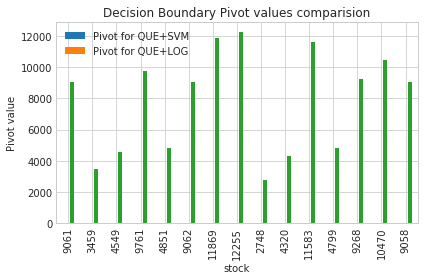

In [38]:
df_pivot.plot(kind='bar')
plt.legend(['Pivot for QUE+SVM', 'Pivot for QUE+LOG'])
plt.title('Decision Boundary Pivot values comparision')
plt.ylabel('Pivot value')
plt.tight_layout()
plt.savefig('que_svm_log_pivot_lin.png')

In [29]:
df_pivot['stock'] = df_pivot.index
df_pivot[['stock', 'pivot']].to_csv('que_svm_lin_pivot.csv')

In [45]:
df_piv_lin = pd.read_csv('que_svm_lin_pivot.csv')
df_piv_sig = pd.read_csv('que_svm_sig_pivot.csv')
df_piv_rbf = pd.read_csv('que_svm_rbf_pivot.csv')
df_piv_log = pd.read_csv('que_log_pivot.csv')

df_p = pd.merge(df_piv_lin, df_piv_rbf, on='stock', suffixes=['_lin', '_rbf'])
df_p = pd.merge(df_p, df_piv_sig, on='stock', suffixes=['', '_sig'])
df_p.rename(columns={'pivot': 'pivot_sig'}, inplace=True)
df_p = pd.merge(df_p, df_piv_log, on='stock', suffixes=['', '_log'])
df_p.index = df_p['stock']
df_p

,stock,stock.1_lin,pivot_lin,stock.1_rbf,pivot_rbf,stock.1,pivot_sig,Unnamed: 0,pivot
stock,,,,,,,,,
9061,9061,9061,0.004681,9061,0.111936,9061,-0.000036,9061,0.023023
3459,3459,3459,0.053809,3459,0.063351,3459,0.046621,3459,0.096860
4549,4549,4549,0.017009,4549,0.020534,4549,-0.000026,4549,0.032053
9761,9761,9761,0.033628,9761,0.071641,9761,0.171668,9761,0.043341
4851,4851,4851,0.082681,4851,0.121941,4851,-0.050287,4851,0.089948
9062,9062,9062,0.001804,9062,0.004079,9062,-0.090466,9062,0.012105
11869,11869,11869,0.036864,11869,0.038638,11869,0.033717,11869,0.037273
12255,12255,12255,0.033047,12255,0.023962,12255,-0.000888,12255,0.046640
2748,2748,2748,0.021029,2748,0.158208,2748,-0.000039,2748,0.038263


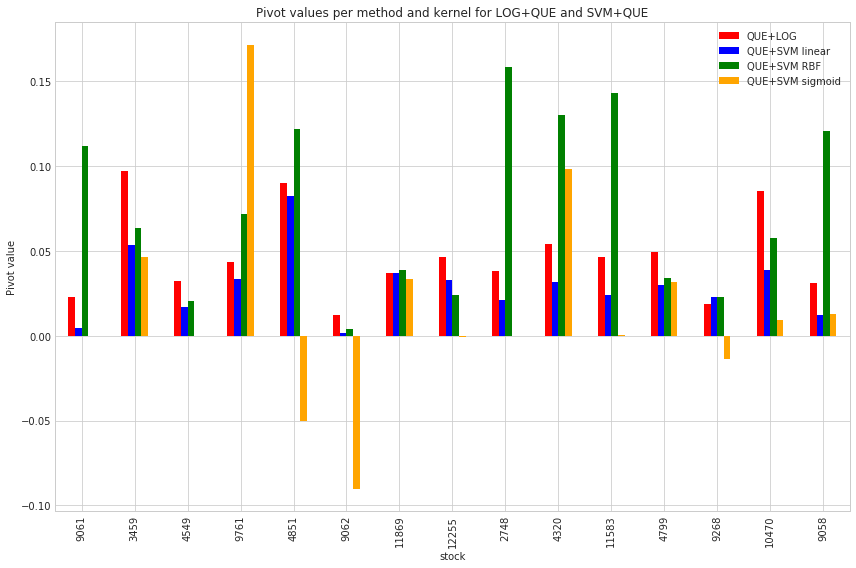

In [66]:
df_p[['pivot', 'pivot_lin', 'pivot_rbf', 'pivot_sig']].plot(kind='bar', figsize=(12, 8), 
                                                            colors=['r', 'blue', 'g', 'orange'])
plt.tight_layout()
plt.ylabel('Pivot value')
plt.title('Pivot values per method and kernel for LOG+QUE and SVM+QUE')
plt.legend(['QUE+LOG', 'QUE+SVM linear', 'QUE+SVM RBF', 'QUE+SVM sigmoid'])
plt.tight_layout()
if should_save_fig:
    plt.savefig('que_svm_log_pivot.png')